## 与学习相关的技巧

本章涉及寻找最优权重参数的最优化方法、权重参数的初始值、超参数的设定方法等。此外，为了应对过拟合，本章还将介绍权值衰减、Dropout等正则化方法。最后对近年来众多研究中使用的 Batch Normalization 方法进行简单的介绍。使用本章介绍的方法，可以高效地进行神经网络（深度学习）的学习，提高识别精度。

### 参数更新
神经网络的学习的目的是找到使损失函数的值尽可能小的参数。这是寻找最优参数的问题，解决这个问题的过程称为**最优化(optimization)**。<br>
前几章中，为了找到最优参数，我们将参数的梯度(导数)作为线索。使用参数的梯度，沿梯度方向更新参数，并重复这个步骤多次，从而逐渐靠近最优参数，这个过程称为**随机梯度下降法**(stochastic gradient descent)，简称**SGD**。SGD是一个简单地方法，也算是“聪明”的方法。但是，根据不同的问题，也存在比SGD更聪明的方法。我们将指出SGD的缺点，并介绍SGD以外的其他最优化方法。


#### SGD
用数学式可以将SGC写成如下的式子。
$$
W \leftarrow W - \eta \frac {\partial L}{\partial W}
$$
这里把需要更新的权重参数记 $W$，把损失函数关于 $W$ 的梯度记为 $\frac {\partial L}{\partial W}$，$\eta$表示学习率，实际上会取0.01或0.001这些事先决定好的值。式子中的$\leftarrow$表示用右边的值更新左边的值。如上式，SGD是朝着梯度方向只能前进一定距离的简单方法。

现在，我们将SGD实现为一个Python类。

In [1]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
    
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

这里，进行初始化时的参数 lr 表示 learning rate(学习率)。这个学习率会保存为实例变量。此外，代码段中还定义了 update(params, grads) 方法，这个方法在 SGD 中会被反复调用。参数 params 和 grads 是字典型变量，按 params['W1']、grads['W2'] 的形式，分别保存了权重参数和它们的梯度。

使用这个 SGD 类，可以按照如下方式进行神经网络的参数的更新。（下面的代码是不能运行的伪代码）

In [ ]:
network = TwoLayerNet(...)
optimizer = SGD() # “进行最优化的人”，由SGD承担这个角色

for i in range(10000):
    ...
    x_batch, t_batch = get_mini_batch() # mini-batch
    grads = network.gradient(x_batch, t_batch)
    params = network.params
    optimizer.update(params, grads)
    ...

参数的更新由 optimizer 表示负责完成。我们在这里需要做的只是将参数和梯度的信息传给 optimizer。像这样，通过单独实现进行最优化的类，功能的模块化变得更简单。比如，后面我们实现另一个最优化方法 Momentum ，它同样会实现成拥有 update(params, grads) 这个共同方法的形式。这样一来，只需要将`optimizer = SGD()`这一语句换成`optimizer = Momentum()`，就可以从 SCD 切换为 Momentum。

#### SGD的缺点
如果函数的形状非均向(anisotropic)，比如呈延伸状，搜索的路径就会非常低效。低效的根本原因是，梯度的方向并没有指向最小值的方向。



#### Momentum
Momentum 是“动量”的意思，和物理有关。用数学式表示 Momentum 方法，如下所示。
$$
v \leftarrow \alpha v - \eta \frac{\partial L }{\partial W}
$$
$$
W \leftarrow W + v
$$

$W$表示要更新的权重参数，$\frac{\partial L }{\partial W}$表示损失函数关于$W$的梯度，$\eta$表示学习率。变量$v$对应物理上的速度。上式表示了物体在梯度方向上受力，在这个力的作用下，物体的速度增加这一物理法则。

式中有$av$这一项。在物体不收任何力时，该项承担使物体逐渐减速的任务（$a$设定为0.9之类的值），对应物理上的地面摩擦或空气阻力。

下面是 Momentum 的代码实现。

In [20]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9): # 初始化对象
        self.lr = lf
        self.momentum = momentum
        slef.v = None # 保存变量的速度，初始化时，v中什么都不保存
    
    def update(self, params, grads):
        if self.v is None: # 第一次调用update()时，v以字典型变量的形式保存与参数结构相同的数据
            self.v = {}
            for key,val in params.items():
                self.v[key] = np.zeros_like(val)
                
            for key in params.keys(): # 数学式的代码化
                self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
                params[key] += self.v[key]

#### AdaGrad
在神经网络的学习中，学习率$/eta$的值很重要。学习率过小，会导致学习花费过多时间；学习率过大，会导致学习发散而不能正确进行。AdaGrad 会为参数的每个元素适当地调整学习率。用数学式表示 AdaGrad 的更新方法如下。
$$
h \leftarrow h + \frac{\partial L}{\partial W} \odot \frac{\partial L}{\partial W}
$$
$$
W \leftarrow W - \eta \frac{1}{\sqrt{h}} \frac{\partial L}{\partial W}
$$
和前面的 SGD 一样，$W$b表示要更新的权重参数，$\frac {\partial L}{\partial W}$表示损失函数关于$W$的梯度，$\eta$表示学习率。新出现的变量$h$，保存了以前的所有梯度值的平方和（$\odot$表示对应矩阵元素的乘法）。在更新参数时，乘以$\frac{1}{\sqrt{n}}$，以调整学习的尺度。说明参数的元素中变动较大的元素的学习率将变小。也就是说，可以按参数的元素进行学习率衰减，使变动大的参数的学习率逐渐减小。

AdaGrad 会记录过去所有的梯度的平方和。因此学习越深入，更新的幅度就越小。

AdaGrad 的实现过程如下。

In [25]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7) # 加微小值1e-7是为了防止当self.h[key]中有0时，将0用作除数

#### Adam
Momentum 参照小球在碗里滚动的物理规则进行移动，AdaGrad 为参数的每个元素适当地调整更新步伐。如果将这两个方法融合在一起，就是 Adam 方法的基本思路。

Adam 是2015年提出的新方法。理论有点复杂，直观地讲，就是融合了 Momentum 和 AdaGrad 的方法。通过组合前面两个方法的有点，有望实现参数空间的高效搜索。此外，进行超参数的“偏置校正”也是 Adam 的特征。不再做过多说明，详细内容参考原作者的论文。

Adam 会设置3个超参数。一个是学习率，另外两个是 **1次momentum系数$\beta1$** 和 **2次momentum系数$\beta2$** 。根据论文，标准的设定值是$\beta1$为0.9，$\beta2$为0.999。

Adam的实现如下。

In [28]:
class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

#### 更新方法的选取
我们上面介绍了4种更新参数的方法，这里我们来比较一下这4种方法。（看图）

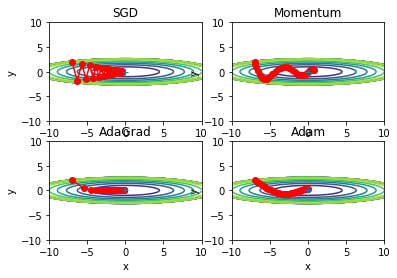

In [30]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from common.optimizer import *


def f(x, y):
    return x**2 / 20.0 + y**2


def df(x, y):
    return x / 10.0, 2.0*y

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

idx = 1

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # for simple contour line  
    mask = Z > 7
    Z[mask] = 0
    
    # plot 
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")
    
plt.show()

如图所示，根据使用的方法不同，参数更新的路径也不同。只看这个图的话，AdaGrad 似乎是最好的，不过要注意，**结果会根据要解决的问题而变**。并且，**超参数（学习率等）的设定值不同，结果也会发生变化**。

（目前）并不存在能在所有问题中都表现良好的方法。这4种方法各有各的特点，都有各自擅长解决的问题和不擅长解决的问题。


#### 基于 MNIST 数据集的更新方法的比较
以手写数字识别为例，比较前面介绍的 SGD、Momentum、AdaGrad、Adam 这4种方法，并确认不同的方法在学习进展上有多大程度的差异。看下面这张图。

===========iteration:0===========
SGD:2.327378106678742
Momentum:2.4049215789156895
AdaGrad:2.290763811790712
Adam:2.1898127549911663
===========iteration:100===========
SGD:1.614666492473536
Momentum:0.22105673362000888
AdaGrad:0.12947326764306843
Adam:0.19330676994222087
===========iteration:200===========
SGD:0.8544323525258657
Momentum:0.23278046158730312
AdaGrad:0.10859212000013711
Adam:0.10289128942472983
===========iteration:300===========
SGD:0.593402662704506
Momentum:0.178035387715115
AdaGrad:0.1075022853170095
Adam:0.16982718299551386
===========iteration:400===========
SGD:0.46890966126445066
Momentum:0.22015909234490139
AdaGrad:0.11689798413915922
Adam:0.20639896585044237
===========iteration:500===========
SGD:0.46413597815792407
Momentum:0.21203287621770817
AdaGrad:0.08937445071946183
Adam:0.12284042487102655
===========iteration:600===========
SGD:0.34391359148269973
Momentum:0.16485131590829427
AdaGrad:0.09417850053614006
Adam:0.15267389272048418
===========iteration:7

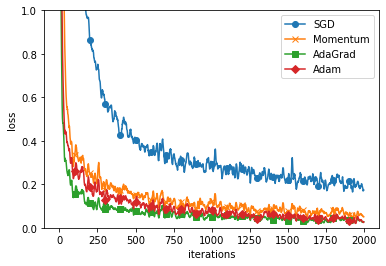

In [31]:
# coding: utf-8
import os
import sys
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *


# 0:读入MNIST数据==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1:进行实验的设置==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2:开始训练==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3.绘制图形==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

这个实验以一个5层神经网络为对象，其中每层有100个神经元。激活函数使用的是ReLU。

从图中结果可知，AdaGrad 学习进行的最快，然后是 Adam，接下来是 Momentum，最后是 SGD。